# Step 1: Install Libraries and Import Dependencies


To start, install the necessary Python libraries:



In [33]:
!pip install pandas numpy seaborn matplotlib scikit-learn statsmodels keras pmdarima catboost lightgbm xgboost transformers dask[dataframe] imbalanced-learn tensorflow keras-tuner



# import all the required libraries:

In [34]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from pmdarima import auto_arima
from keras.models import Sequential
from keras.layers import LSTM, Dense
import warnings

# Ignore warnings
warnings.filterwarnings("ignore")


# Step 2: Load the Datasets
Specify the paths and load your datasets.



In [35]:
# Load the Datasets
large_data_path = r"C:\Users\sande\Music\BI\Data_Set\ecommerce_customer_data_large.csv"
custom_ratios_path = r"C:\Users\sande\Music\BI\Data_Set\ecommerce_customer_data_custom_ratios.csv"

df_large = pd.read_csv(large_data_path)
df_custom = pd.read_csv(custom_ratios_path)


# Step 3: Concatenate the Datasets
Merge the two datasets into one.



In [36]:
# Concatenate Datasets
df_combined = pd.concat([df_large, df_custom])
df_combined.reset_index(drop=True, inplace=True)


# Step 4: Exploratory Data Analysis (EDA)
You can explore the combined dataset to understand its structure and contents:



Missing values in combined dataset:
 Customer ID                  0
Purchase Date                0
Product Category             0
Product Price                0
Quantity                     0
Total Purchase Amount        0
Payment Method               0
Customer Age                 0
Returns                  94978
Customer Name                0
Age                          0
Gender                       0
Churn                        0
dtype: int64
         Customer ID  Product Price       Quantity  Total Purchase Amount  \
count  500000.000000  500000.000000  500000.000000          500000.000000   
mean    25010.834166     254.701118       3.001916            2725.377964   
std     14420.386990     141.653230       1.414717            1442.753398   
min         1.000000      10.000000       1.000000             100.000000   
25%     12545.000000     132.000000       2.000000            1477.000000   
50%     25014.000000     255.000000       3.000000            2725.000000   
75%     

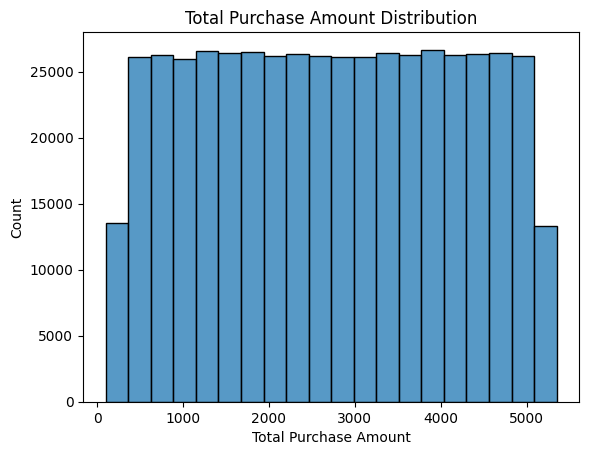

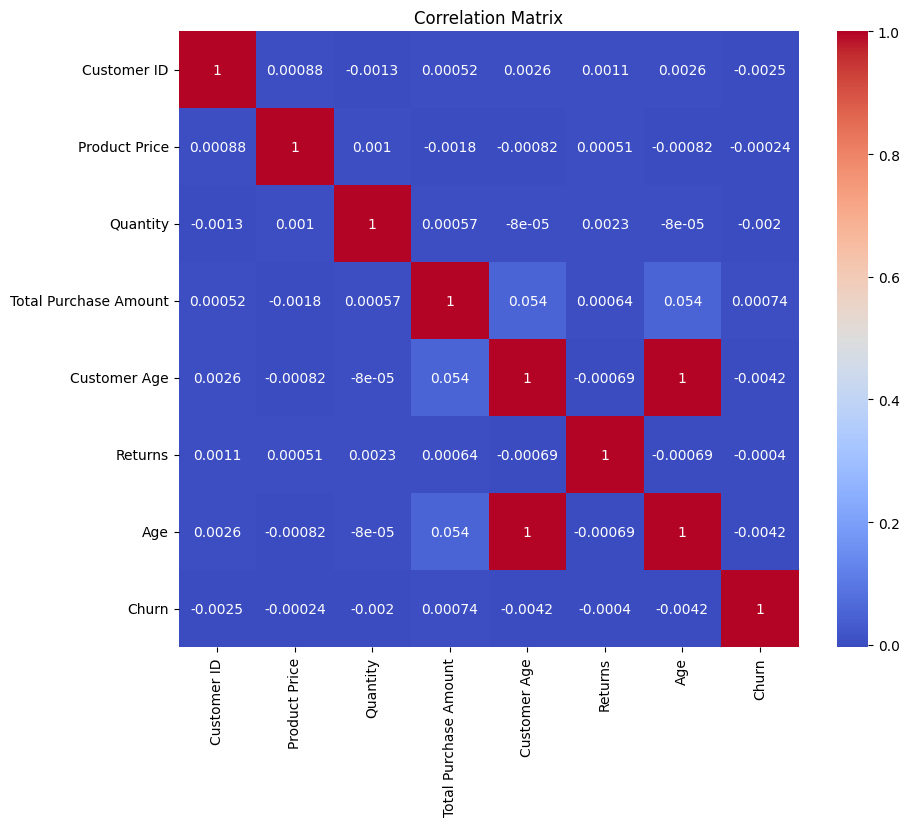

In [37]:
# Check for missing values
print("Missing values in combined dataset:\n", df_combined.isnull().sum())

# Summary statistics of numerical columns
print(df_combined.describe())

# Impute missing values in 'Returns' and 'Age'
df_combined['Returns'].fillna(0, inplace=True)
df_combined['Age'].fillna(df_combined['Age'].mean(), inplace=True)

# Visualize the distribution of purchase amounts
sns.histplot(df_combined['Total Purchase Amount'], bins=20)
plt.title("Total Purchase Amount Distribution")
plt.show()

# Check the correlation between numerical features
numeric_df = df_combined.select_dtypes(include=[np.number])  # Only numeric columns
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()


# Step 5: Data Preprocessing
Drop irrelevant columns, handle dates, and prepare data for modeling.



In [38]:
# Drop irrelevant columns
columns_to_drop = ['Customer Name', 'Customer ID']
df_combined = df_combined.drop(columns=[col for col in columns_to_drop if col in df_combined.columns])

# Handle 'Purchase Date' column
if 'Purchase Date' in df_combined.columns:
    df_combined['Purchase Date'] = pd.to_datetime(df_combined['Purchase Date'])
    df_combined.set_index('Purchase Date', inplace=True)

# Print columns to check
print("Columns after preprocessing:", df_combined.columns.tolist())

# One-hot encode categorical columns
categorical_columns = ['Product Category', 'Payment Method', 'Gender']
existing_categorical_columns = [col for col in categorical_columns if col in df_combined.columns]
df_combined = pd.get_dummies(df_combined, columns=existing_categorical_columns, drop_first=True)


Columns after preprocessing: ['Product Category', 'Product Price', 'Quantity', 'Total Purchase Amount', 'Payment Method', 'Customer Age', 'Returns', 'Age', 'Gender', 'Churn']


# Step 6: Split Features and Target
Define the target variable and split the data.



In [39]:
# Split features and target
X = df_combined.drop('Churn', axis=1)
y = df_combined['Churn']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize numerical features
numeric_cols = ['Product Price', 'Quantity', 'Total Purchase Amount', 'Age']
scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled[numeric_cols] = scaler.transform(X_test[numeric_cols])


# Step 7: Handle Class Imbalance using SMOTE
Balance the dataset using SMOTE to handle imbalanced classes.



In [40]:
# Apply SMOTE for class imbalance
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)


# Step 8: Train and Evaluate Models
Train multiple models and evaluate their performance.



In [41]:
# Define models
models = {
    "LogisticRegression": LogisticRegression(class_weight='balanced', max_iter=300, solver='liblinear'),
    "RandomForest": RandomForestClassifier(class_weight='balanced'),
    "GradientBoosting": GradientBoostingClassifier(),
    "HistGradientBoosting": HistGradientBoostingClassifier(),
    "CatBoost": CatBoostClassifier(verbose=False),
    "LightGBM": LGBMClassifier(),
    "XGBoost": XGBClassifier()
}

# Function to evaluate models
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"\nModel Evaluation:\nAccuracy: {accuracy:.4f}\nPrecision: {precision:.4f}\nRecall: {recall:.4f}\nF1 Score: {f1:.4f}")
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Train and evaluate models
for name, model in models.items():
    model.fit(X_train_balanced, y_train_balanced)
    print(f"{name} trained successfully.")
    evaluate_model(model, X_test_scaled, y_test)


LogisticRegression trained successfully.

Model Evaluation:
Accuracy: 0.5883
Precision: 0.6812
Recall: 0.5883
F1 Score: 0.6236

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.65      0.71     79956
           1       0.20      0.36      0.26     20044

    accuracy                           0.59    100000
   macro avg       0.50      0.50      0.49    100000
weighted avg       0.68      0.59      0.62    100000

RandomForest trained successfully.

Model Evaluation:
Accuracy: 0.7097
Precision: 0.6800
Recall: 0.7097
F1 Score: 0.6936

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.85      0.82     79956
           1       0.20      0.15      0.17     20044

    accuracy                           0.71    100000
   macro avg       0.50      0.50      0.50    100000
weighted avg       0.68      0.71      0.69    100000

GradientBoosting trained successfully.

Model Ev

# Step 9: Time Series Forecasting (ARIMA & LSTM)
You can forecast future values using ARIMA and LSTM models:




# ARIMA


In [42]:
# Time series aggregation by month
df_time_series = df_combined['Total Purchase Amount'].resample('M').sum().dropna()

# ARIMA Model
model_arima = auto_arima(df_time_series, seasonal=True, stepwise=True, suppress_warnings=True)
forecast_arima = model_arima.predict(n_periods=12)  # Forecast for the next 12 months
print("ARIMA Forecast:", forecast_arima)


ARIMA Forecast: 2023-10-31    4.242621e+07
2023-11-30    2.170736e+07
2023-12-31    3.678726e+07
2024-01-31    2.581158e+07
2024-02-29    3.380007e+07
2024-03-31    2.798577e+07
2024-04-30    3.221762e+07
2024-05-31    2.913753e+07
2024-06-30    3.137932e+07
2024-07-31    2.974767e+07
2024-08-31    3.093525e+07
2024-09-30    3.007089e+07
Freq: ME, dtype: float64


# LSTM

In [43]:
# Prepare data for LSTM
def prepare_lstm_data(data, time_step=30):
    data = data.values
    X, y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i-time_step:i])
        y.append(data[i])
    return np.array(X), np.array(y)

X_lstm, y_lstm = prepare_lstm_data(df_time_series)
X_lstm = X_lstm.reshape((X_lstm.shape[0], X_lstm.shape[1], 1))

# Create LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(X_lstm.shape[1], 1)))
lstm_model.add(LSTM(50))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the LSTM model
lstm_model.fit(X_lstm, y_lstm, epochs=50, batch_size=32)

# Forecast the next month
lstm_input = df_time_series.values[-30:].reshape((1, 30, 1))
lstm_prediction = lstm_model.predict(lstm_input)
print("LSTM Forecast:", lstm_prediction)


Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 891535553986560.0000
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 891535553986560.0000
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 891535553986560.0000
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 891535486877696.0000
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 891535553986560.0000
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 891535553986560.0000
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 891535553986560.0000
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 891535553986560.0000
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 891535419768832.0000
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 891535419768832.0000
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 891535419768832.0000
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 891535419768832.0000
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 89153

# Step 10: Compare ARIMA and LSTM Forecasts
Visualize and compare the forecasts from ARIMA and LSTM:



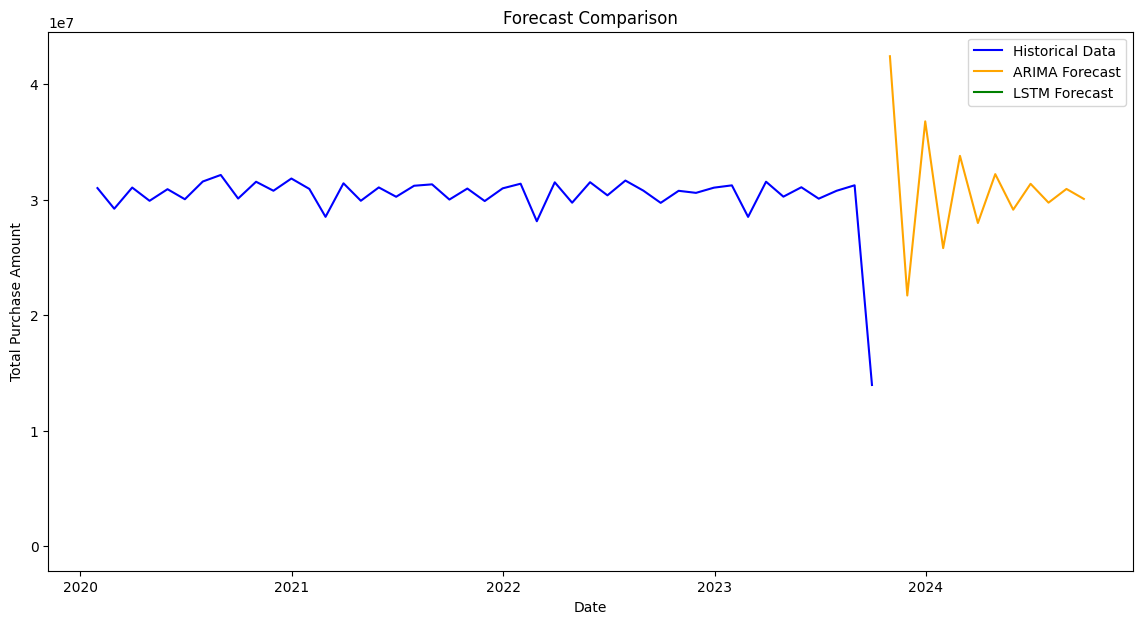

In [44]:
# Plotting ARIMA and LSTM forecasts
plt.figure(figsize=(14, 7))
plt.plot(df_time_series, label='Historical Data', color='blue')
plt.plot(pd.date_range(start='2023-10-31', periods=12, freq='M'), forecast_arima, label='ARIMA Forecast', color='orange')
plt.plot(pd.date_range(start='2023-10-31', periods=1, freq='M'), lstm_prediction.flatten(), label='LSTM Forecast', color='green')
plt.title('Forecast Comparison')
plt.xlabel('Date')
plt.ylabel('Total Purchase Amount')
plt.legend()
plt.show()


# Step 11: Model Refinement & Hyperparameter Tuning

Now that you’ve compared ARIMA and LSTM, you should aim to refine these models further. You can achieve this by tuning the hyperparameters for better performance and ensuring the model fits the data well.

# ARIMA 

In [46]:
import pandas as pd
import pmdarima as pm

# Step 1: Load the Dataset
# Replace the path with your actual file path
large_data_path = r"C:\Users\sande\Music\BI\Data_Set\ecommerce_customer_data_large.csv"
custom_ratios_path = r"C:\Users\sande\Music\BI\Data_Set\ecommerce_customer_data_custom_ratios.csv"

df_large = pd.read_csv(large_data_path)
df_custom = pd.read_csv(custom_ratios_path)

# Step 2: Concatenate the Datasets
df_combined = pd.concat([df_large, df_custom])
df_combined.reset_index(drop=True, inplace=True)

# Step 3: Convert 'Purchase Date' to datetime and set it as index
df_combined['Purchase Date'] = pd.to_datetime(df_combined['Purchase Date'])
df_combined.set_index('Purchase Date', inplace=True)

# Step 4: Extract the relevant column for the time series
data = df_combined['Total Purchase Amount']

# Step 5: Fit the ARIMA Model
model_auto = pm.auto_arima(data, start_p=1, start_q=1, max_p=5, max_q=5, seasonal=False)

# Show the model summary
print(model_auto.summary())


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:               500000
Model:               SARIMAX(1, 0, 0)   Log Likelihood            -4346618.486
Date:                Tue, 22 Oct 2024   AIC                        8693242.972
Time:                        17:59:16   BIC                        8693276.339
Sample:                             0   HQIC                       8693252.418
                             - 500000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2713.6818      4.364    621.772      0.000    2705.128    2722.236
ar.L1          0.0043      0.001      3.034      0.002       0.002       0.007
sigma2      2.081e+06   6557.345    317.430      0.0

# LSTM

In [53]:
# Step 1: Import necessary libraries
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras_tuner import RandomSearch
from keras.callbacks import EarlyStopping  # Import EarlyStopping

# Step 2: Prepare the LSTM data
def create_dataset(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps)])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

# Step 3: Load and preprocess the data
large_data_path = r"C:\Users\sande\Music\BI\Data_Set\ecommerce_customer_data_large.csv"
custom_ratios_path = r"C:\Users\sande\Music\BI\Data_Set\ecommerce_customer_data_custom_ratios.csv"
df_large = pd.read_csv(large_data_path)
df_custom = pd.read_csv(custom_ratios_path)
df_combined = pd.concat([df_large, df_custom])

# Ensure the 'Purchase Date' is datetime and set it as the index
df_combined['Purchase Date'] = pd.to_datetime(df_combined['Purchase Date'])
df_combined.set_index('Purchase Date', inplace=True)

# Step 4: Extract 'Total Purchase Amount' and scale the data
data = df_combined['Total Purchase Amount'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# Step 5: Define time steps and create dataset
time_steps = 30  # Use 30 time steps as an example
X, y = create_dataset(data_scaled, time_steps)

# Reshape the data for LSTM input
X = X.reshape((X.shape[0], X.shape[1], 1))  # Shape: (samples, timesteps, 1)

# Define timesteps and features for the model
timesteps = X.shape[1]  # 30 time steps
features = X.shape[2]   # 1 feature (Total Purchase Amount)

# Step 6: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 7: Define the build_model function for Keras Tuner
def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=256, step=32),
                   input_shape=(timesteps, features)))  # Input shape for LSTM
    model.add(Dense(1))  # Output layer
    model.compile(optimizer='adam', loss='mse')
    return model

# Step 8: Initialize the Keras Tuner
tuner = RandomSearch(build_model, objective='val_loss', max_trials=5, executions_per_trial=3)

# Step 9: Fit the tuner on the training data with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Fit the tuner with the early stopping callback
tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[early_stopping])


Trial 5 Complete [01h 13m 23s]
val_loss: 0.07539477447668712

Best val_loss So Far: 0.07539392014344533
Total elapsed time: 06h 04m 27s


In [54]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the optimal number of units
print(f"The optimal number of units is: {best_hps.get('units')}")

# Build the best model with the optimal hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Train the best model
best_model.fit(X_train, y_train, epochs=50, validation_split=0.2)

# Evaluate the best model
loss = best_model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")


The optimal number of units is: 192
Epoch 1/50
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 135s 13ms/step - loss: 0.0771 - val_loss: 0.0754
Epoch 2/50
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 138s 14ms/step - loss: 0.0758 - val_loss: 0.0754
Epoch 3/50
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 140s 14ms/step - loss: 0.0757 - val_loss: 0.0756
Epoch 4/50
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 141s 14ms/step - loss: 0.0756 - val_loss: 0.0754
Epoch 5/50
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 143s 14ms/step - loss: 0.0758 - val_loss: 0.0755
Epoch 6/50
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 144s 14ms/step - loss: 0.0756 - val_loss: 0.0754
Epoch 7/50
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 144s 14ms/step - loss: 0.0757 - val_loss: 0.0755
Epoch 8/50
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 148s 15ms/step - loss: 0.0757 - val_loss: 0.0754
Epoch 9/50
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 148s 15ms/step - loss: 0.0756 - val_loss: 0.0754
Epoch 10/50
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 147s 15ms/step - loss: 0.0756 - val_loss: 0.0754
Epoch 11/50
10000/10000 ━━━━━━━━━

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step


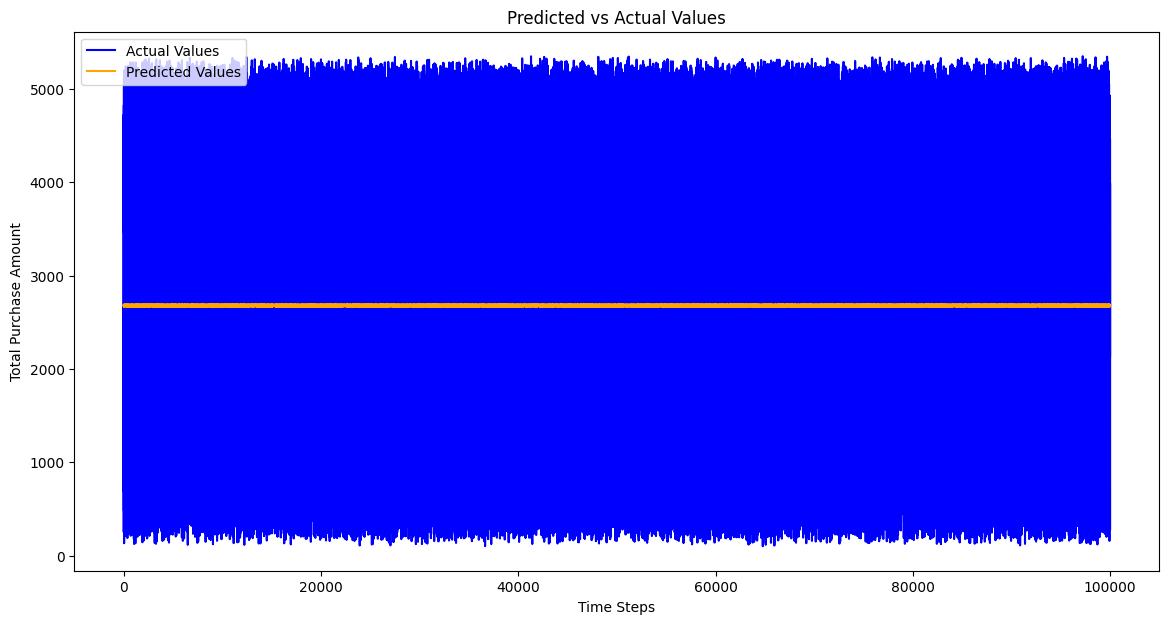

In [55]:
import matplotlib.pyplot as plt

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Inverse transform the predictions and actual values back to original scale
y_pred_inverse = scaler.inverse_transform(y_pred)
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(y_test_inverse, label='Actual Values', color='blue')
plt.plot(y_pred_inverse, label='Predicted Values', color='orange')
plt.title('Predicted vs Actual Values')
plt.xlabel('Time Steps')
plt.ylabel('Total Purchase Amount')
plt.legend()
plt.show()


In [56]:
# Save the model
best_model.save('best_lstm_model.h5')
print("Model saved as 'best_lstm_model.h5'")


Model saved as 'best_lstm_model.h5'


In [62]:
import pandas as pd

# Step 1: Load the new dataset
new_data_path = r"C:\Users\sande\Music\BI\Test_data\data.csv"  # Update with the correct file name


In [68]:
import csv
import pandas as pd
import numpy as np

# Read the CSV with correct parameters
new_df = pd.read_csv(
    new_data_path,
    sep=';',             # Use semicolon as separator
    decimal=',',         # Use comma as decimal separator
    encoding='utf-8'     # Specify encoding
)

# Print the first few rows to verify
print("\nFirst few rows of the dataframe:")
print(new_df.head())

# Print column names to verify
print("\nColumn names:")
print(new_df.columns.tolist())

# Print basic information about the dataframe
print("\nDataframe info:")
print(new_df.info())

# Get numerical columns for LSTM input (excluding 'churn' which is our target)
numerical_columns = new_df.select_dtypes(include=[np.number]).columns.tolist()
numerical_columns.remove('churn')  # Remove target variable

# Prepare features (X) and target (y)
X = new_df[numerical_columns].values
y = new_df['churn'].values



First few rows of the dataframe:
   account length  location code  user id credit card info save push status  \
0             128            415  3824657                    no         yes   
1             107            415  3717191                    no         yes   
2             137            415  3581921                    no          no   
3              84            408  3759999                   yes          no   
4              75            415  3306626                   yes          no   

   add to wishlist  desktop sessions  app sessions  desktop transactions  \
0               25               265            45                    17   
1               26               162            27                    17   
2                0               243            41                    10   
3                0               299            51                     5   
4                0               167            28                    13   

   total product detail views  ses